## Image Segmentation Model

This notebook is an attempt to put into use what I've learned so far. The goal is the following: be able to prepare a dataset made of images, train a deep learning model with it and be able to use this model on new data to produce unsupervised results.
The model has to segment a given image and label each segment. Those images are aerial/satellite pictures and we want to automatically extract areas with recognizable structures like buildings, roads or vegetation on the pictures.

![satellite picture](./dataset/Tile%201/images/image_part_001.jpg) ![mask output](./dataset/Tile%201/masks/image_part_001.png)

### The dataset

In order to accomplish that, I need a dataset made of Earth pictures and a labeled mask for each of these pictures.
The "Semantic segmentation of aerial imagery" is an open dataset made of satellite images of Dubai and their mask couterpart that I will attempt to use for this project.

### The model

After looking for a model that take images as its input and its output in order to represent information over said images, the encoder-decoder architecture seems to be a good choice. Especially the U-Net model is made for this exact kind of applications. I will try to use this model for this project.

First, imports:

In [1]:
from pathlib import Path
import os
from PIL import Image
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import numpy as np

First, we get the images and masks paths:

In [2]:
data_path = Path(".") / "dataset"

tiles = ["Tile " + str(i) for i in range(1, 9)]

images_root_paths = [Path(data_path) / tile / "images" for tile in tiles]
masks_root_paths = [Path(data_path) / tile / "masks" for tile in tiles]

image_extension = '.jpg'
mask_extension = '.png'

In [3]:
images_paths = []
for path in images_root_paths:
	images_paths += [Path(path) / image for image in os.listdir(path) if os.path.isfile(Path(path) / image) and image.endswith(image_extension)]

masks_paths = []
for path in masks_root_paths:
	masks_paths += [Path(path) / mask for mask in os.listdir(path) if os.path.isfile(Path(path) / mask) and mask.endswith(mask_extension)]

assert len(images_paths) == len(masks_paths) , "Not the same amount of images and masks paths."

print(f"{len(images_paths)} elements in dataset.")

72 elements in dataset.


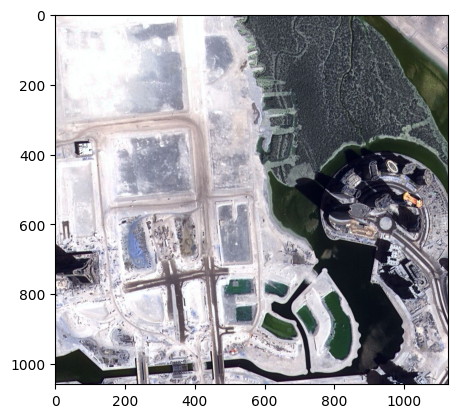

In [4]:
# Quick check to see if it's ok.
with Image.open(images_paths[42]) as img:
	plt.imshow(img)

I now have all the paths for the images and masks from the dataset.
Let's now prepare those. The first step is to split the shape of our images to standardize the input our model will take. We'll use the patchify library.
After documenting, I shall choose a patch size which is a 32 multiple. 128, 256 and 512 appear to be the most common choices.

In [5]:
patch_size = 256

(4, 4, 1, 256, 256, 3)


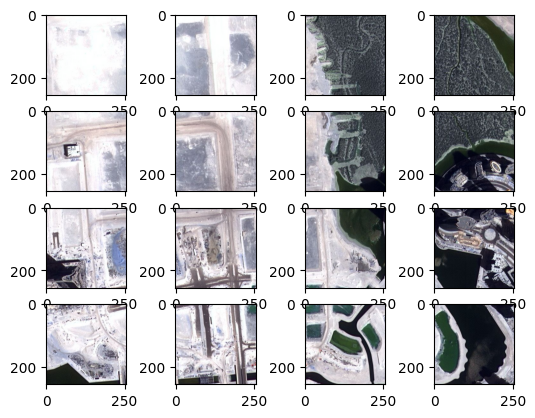

In [6]:
with Image.open(images_paths[42]) as img:
	img = np.array(img)
	patches = patchify(img, patch_size=(patch_size, patch_size, 3), step=patch_size)

	print(patches.shape)

	f, ax = plt.subplots(len(patches), len(patches[0]))
	i = 0
	for patch_x in patches:
		j = 0
		for patch_y in patch_x:
			ax[i, j].imshow(patch_y[0])
			j += 1
		i += 1

In [7]:
# In case flattening the patch list is needed later...
print(patches.shape)
patches_flat = patches.reshape(len(patches) * len(patches[0]) * len(patches[0][0]), patch_size, patch_size, 3)
print(patches_flat.shape)

(4, 4, 1, 256, 256, 3)
(16, 256, 256, 3)


Let's patchify all our data:

In [8]:
patched_images = []
for path in images_paths:
	image = Image.open(path)

	if (image.mode != 'RGB'):
		image = image.convert('RGB')

	image_arr = np.array(image)
	patches = patchify(image_arr, patch_size=(patch_size, patch_size, 3), step=patch_size)

	for patch_x in patches:
		for patch_y in patch_x:
			for patch in patch_y:
				patched_images.append(patch)

patched_masks = []
for path in masks_paths:
	mask = Image.open(path)

	if (mask.mode != 'RGB'):
		mask = mask.convert('RGB')

	mask_arr = np.array(mask)
	patches = patchify(mask_arr, patch_size=(patch_size, patch_size, 3), step=patch_size)

	for patch_x in patches:
		for patch_y in patch_x:
			for patch in patch_y:
				patched_masks.append(patch)


assert len(patched_images) == len(patched_masks), "Not the same amount of patches for images and masks."
print(f"Total number of elements: {len(patched_images)}")


Total number of elements: 1305


We now have our data with the correct shape! We need to normalize it now.